# Coding Assignment - 4
## MATH-GA 2805 Trends in Sell-Side Modelling
#### Abhishek Kulkarni (ask9103)
#### Lavaneesh Sharma (lss8875)

********

We continue with the interest rate setup from Coding Assignment 2. That is, we consider a market where we have established at time $0$ (e.g., by looking at quoted swap and futures prices) that the risk-free forward interest rate curve is given by 

$$f(0,t) = a + b.t$$

where $a=2.5\%\;\&\;b = 0.2\%$

The dynamics of the forward curve $f(t,T)$ are as in Coding Assignment 2: a 2-factor Gaussian model with $\sigma_{r}=2\%, c=40\%, \kappa_{2}=5\%, \rho_{\infty}=40\%$

We also consider, as in Coding Assignment 2, a 10-year semi-annual interest rate swap. Let the notional of the swap be $USD\;50\;million$ and let its coupon be $h$.

In Coding Assignment 3, you established the expected exposure $(EE)$ profile for the payer and receiver swaps, on a (roughly) weekly grid spanning $[0, 10yrs]$. You did this for a variety of collateral agreements and for coupons of $h = 2\%, h = 4\%, h = 6\%, h = 8\%$. You also established, among other things, the unilateral and bilateral CVA, for a bank trading with a counterparty $A$ with a flat risk-neutral intensity $\lambda_{A} = 4.5\%$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos, exp, pi
from scipy.optimize import fsolve
import random
from scipy.stats import norm

In [2]:
class SwapPricer:
    
    def __init__(self,a,b,c,rho_inf,sig_r,k2,N,T_,ts_):
        self.a       =  a
        self.b       =  b
        self.c       =  c
        self.rho_inf =  rho_inf
        self.sig_r   =  sig_r
        self.k2      =  k2
        self.sig1    =  self.c * self.sig_r
        self.v       =  np.sqrt((1/self.c)**2 - 1 - 2*((self.rho_inf/self.c) - 1))
        self.sig2    =  self.v * self.sig1
        self.px      =  ((self.rho_inf/self.c) - 1)/(self.v)
        self.N       =  N
        self.T_      =  T_
        self.ts_     =  ts_
        self.dt_     =  self.T_[1] - self.T_[0]
    
    def Y(self,sig_,kappa_,t_):
        return ((sig_**2)/(2*kappa_))*(1 - np.exp(-2*kappa_*t_))
    
    def y_mat(self,t_):
        y1 = (self.sig1**2)*t_ + \
        ( ( (self.px**2) * (self.sig1**2) * (self.sig2**2) * (np.exp(2*self.k2*t_) - 1) ) / (2*self.k2) )   
        
        y2 = (((self.sig1**2)*(self.sig2)*self.px )*( np.exp(self.k2*t_) - 1 ) + \
              ( (self.sig2**2) * (self.sig1) * (self.px)) * (np.exp(2*self.k2*t_) - 1)) * np.exp(-self.k2*t_)
        
        y3 = y2
        
        y4 = (((self.sig2**2)*(1 - np.exp(-2*k2*t_)))/(2*self.k2)) + \
        (((self.px**2) * (self.sig1**2) * (self.sig2**2)) * (1 - np.exp(-2*self.k2*t_)))/(2*self.k2)
        
        return y1, y2, y3, y4
    
    
    def simulations(self):
        X1 = np.zeros((self.N,len(self.ts_)))
        X2 = np.zeros((self.N,len(self.ts_)))
        X1[:,0] = 0
        X2[:,0] = 0
        
        dt = self.ts_[1] - self.ts_[0]
        dWx1 = np.random.normal(loc = 0,scale=np.sqrt(dt),size=(self.N,len(self.ts_)-1))
        dWx2 = np.random.normal(loc = 0,scale=np.sqrt(dt),size=(self.N,len(self.ts_)-1))
        dWx2 = self.px*dWx1 + dWx2*np.sqrt(1 - (self.px)**2)
        
        for i in range(0,len(self.ts_)-1):
            l0,l1,l2,l3 = self.y_mat(self.ts_[i])
            X1[:,i+1] = X1[:,i] + (l0 + l1)*dt + self.sig1*dWx1[:,i]
            X2[:,i+1] = X2[:,i] + (l2 + l3 - (self.k2*X2[:,i]))*dt + self.sig2*dWx2[:,i]
        
        return X1,X2
    
    def simulations2(self,l0_,p_l_,p_s_,sig_,kappa_):
        X1 = np.zeros((self.N,len(self.ts_)))
        X2 = np.zeros((self.N,len(self.ts_)))
        l = np.zeros((self.N,len(self.ts_)))
        X1[:,0] = 0
        X2[:,0] = 0
        l[:,0] = l0_
        
        p_1 = p_l_
        p_2 = p_s_ * np.sqrt((self.v**2) + 1 + (2*self.px*self.v)) - p_l_ * self.v
        corr = np.array([[1.0,self.px,p_1],
                         [self.px,1.0,p_2],
                         [p_1,p_2,1.0]])
        
        dt = self.ts_[1] - self.ts_[0]
        dWx1 = np.random.normal(loc = 0, scale=np.sqrt(dt), size=(self.N,len(self.ts_)-1))
        dWx2 = np.random.normal(loc = 0, scale=np.sqrt(dt), size=(self.N,len(self.ts_)-1))
        dWl  = np.random.normal(loc = 0, scale=np.sqrt(dt), size=(self.N,len(self.ts_)-1))
        dWx2 = self.px*dWx1 + dWx2*np.sqrt(1-(self.px)**2)
        const = (p_l_ - self.px*p_s_)/(np.sqrt(1-self.px**2))
        #dWl = p_s_*dWx1 + const*dWx2 +  np.sqrt(1 - p_s_**2 - const**2)*dWl
        dWl = p_1*dWx1 + (p_2-self.px*p_1)/np.sqrt(1-self.px**2)*dWx2 + np.sqrt(1-p_1**2-((p_2-self.px*p_1)/np.sqrt(1-self.px**2)**2))*dWl
        
        for i in range(len(self.ts_)-1):
            y0_,y1_,y2_,y3_ = self.y_mat(self.ts_[i])
            y4_ = self.Y(sig_,kappa_,self.ts_[i])
            X1[:,i+1] = X1[:,i] + (y0_ + y1_)*dt + self.sig1*dWx1[:,i]
            X2[:,i+1] = X2[:,i] + (y2_ + y3_ - (self.k2*X2[:,i]))*dt + self.sig2*dWx2[:,i]
            l[:,i+1]  = l[:,i] + (y4_ - kappa_*l[:,i])*dt + sig_*dWl[:,i]
            
        return X1,X2,l
    
    
    def Plot(self,x1_,x2_):
        figure, axis = plt.subplots(2,1)
        figure.set_figwidth(20)
        figure.set_figheight(10)
        
        for i in range(self.N):
            axis[0].plot(self.ts_,x1_[i,:])
        axis[0].set_title("Two Factor OU Process")
        axis[0].set_ylabel("X1")
        axis[0].set_xlabel("Years")
        axis[0].grid(True)

        for i in range(self.N):
            axis[1].plot(self.ts_,x2_[i,:])
        axis[1].set_xlabel("Years")
        axis[1].set_ylabel("X2")
        axis[1].set_title("Two Factor OU Process")
        axis[1].grid(True)
        plt.show()
    
    
    def A_vec(self,t_):
        v1, v2, v3, v4 = self.y_mat(t_)
        Ttemp = self.T_[self.T_ > t_]
        ttemp = np.ones(len(Ttemp))*t_
        Tdelt = Ttemp - ttemp
        return -0.5*((Tdelt)**2)*v1 - \
        (v3/self.k2)*(Tdelt)*(1-np.exp(-self.k2*(Tdelt))) - \
    0.5*(v4/(self.k2)**2)*(1 - np.exp(-self.k2*(Tdelt)))**2
    
    
    def Pr(self,t_,x1_,x2_):
        Ttemp = self.T_[self.T_ > t_]
        ttemp = np.ones(len(Ttemp))*t_
        T_t = np.tile(Ttemp - ttemp, (self.N,1))
        A = np.tile(self.A_vec(t_), (self.N,1))
        P_0T = np.tile(np.exp(-(self.a*Ttemp + self.b*(Ttemp**2)/2)), (self.N,1))
        P_0t = np.tile(np.exp(-(self.a*ttemp + self.b*(ttemp**2)/2)), (self.N,1))
        t_index = np.where(self.ts_==t_)[0][0]
        CX   = x1_[:,t_index].reshape((self.N,1))*(-T_t) + \
        x2_[:,t_index].reshape((self.N,1))*(np.exp(-self.k2*(T_t)) - 1) / (self.k2)
        
        return (P_0T / P_0t) * np.exp(A + CX)
    
    
    def spot_rate(self,x1_,x2_):
        f_0t = np.tile(self.a + self.b*self.ts_,(self.N,1))
        return f_0t + x1_ + x2_
    
    
    def default_intensity_A(self,l0_,l_):
        lA_0_t = np.ones((self.N,len(self.ts_))) * l0_
        res = lA_0_t + l_
        return res
    
    
    def beta(self,t_,x1_,x2_):
        t_index = np.where(self.ts_==t_)[0][0]
        h = (t_-0)/(len(self.ts_[:t_index+1]))
        r = self.spot_rate(x1_,x2_)
        rt = r[:,:t_index+1]
        return np.exp((h/2)*(rt[:,0] + 2*np.sum(rt[:,1:len(rt)-1], axis=1) + rt[:,-1]))

    
    def StubVal(self,t_,x1_,x2_):
        if t_ in self.T_:
            return np.ones(self.N)
        else:    
            T0 = self.T_[self.T_ < t_][-1]
            return self.beta(t_,x1_,x2_) / self.beta(T0,x1_,x2_) 
    
    def disc_factors(self,x1_,x2_,lA_):
        disc_factors_ = np.ones((self.N,len(self.ts_)))
        rates = self.spot_rate(x1_,x2_) + lA_
        for i in range(len(self.ts_)):
            r = rates[:,:np.where(self.ts_==self.ts_[i])[0][0]+1]
            h = (self.ts_[i]-0)/(len(self.ts_[:np.where(self.ts_==self.ts_[i])[0][0]+1]))
            disc_factors_[:,i] = np.exp(-(h/2)*(r[:,0] + 2*np.sum(r[:,1:len(r)-1],axis=1) + r[:,-1]))   
        return disc_factors_
    
    
    def SwapVal(self,x1_,x2_,c):
        swap = np.zeros((self.N,len(self.ts_)))
        for i in range(len(self.ts_)-1):
            disc_fact = self.Pr(self.ts_[i],x1_,x2_)
            agg_disc_fact = np.sum(disc_fact, axis=1) * c * self.dt_
            stub = self.StubVal(self.ts_[i],x1_,x2_)
            final_term = disc_fact[:,-1] 
            swap_value = agg_disc_fact - stub + final_term
            swap[:,i] = swap_value
        return swap
    
    
    def CVA_theoretical(self,l0_,p_l,p_s,sig_,kappa_,R_,h_,notional_):
        x_1_,x_2_,lmbd = self.simulations2(l0_,p_l,p_s,sig_,kappa_)
        r  = self.spot_rate(x_1_,x_2_)
        lA = self.default_intensity_A(l0_,lmbd)
        dfacs = self.disc_factors(x_1_,x_2_,lA)
        swap_value = self.SwapVal(x_1_,x_2_,h_) * notional_
        
        pEEt_ = np.maximum(-swap_value,0)
        rEEt_ = np.maximum(swap_value,0)
        
        ypCVAu = np.mean(pEEt_ * lA * dfacs,axis=0)
        pCVAu = (1-R_) * np.trapz(y=ypCVAu, x=self.ts_)
        
        yrCVAu = np.mean(rEEt_ * lA * dfacs,axis=0)
        rCVAu = (1-R_) * np.trapz(y=yrCVAu, x=self.ts_)
        
        return pCVAu, rCVAu
    

In [3]:
# MODEL PARAMETERS

a       = 0.025
b       = 0.002
sig_r   = 0.02
c       = 0.4
k2      = 0.05
rho_inf = 0.4

In [4]:
# OBSERVATION GRID
ts = np.arange(0,521)/52   # WEEKLY GRID

In [5]:
# SWAP DEFINITION

notional = 50000000         # SWAP NOTIONAL
maturity = 10               # MATURITY (in Yrs.)
T = np.linspace(0,10,21)    # PAYMENT DATES (in Yrs.)

In [6]:
# NO OF SIMULATIONS
N = 30000

In [7]:
model1 = SwapPricer(a,b,c,rho_inf,sig_r,k2,N,T,ts)
x1, x2 = model1.simulations()
#model1.Plot(x1,x2)

In [8]:
# FINDING h_par

def optimal_h(c):
    swap_price = model1.SwapVal(x1,x2,c)[0][0]
    return swap_price

h_par = fsolve(func=optimal_h, x0=0)[0]
print("Optimal value for coupon is :", h_par)

Optimal value for coupon is : 0.034721066827000255


*******

In [9]:
h1 = np.array([0.02,0.04,0.06,0.08])

In [10]:
model3 = SwapPricer(a,b,c,rho_inf,sig_r,k2,N,T,ts)
x1_3, x2_3 = model3.simulations()
rates3 = model3.spot_rate(x1_3,x2_3)
#model3.Plot(x1_3, x2_3)

In [11]:
swap_prices_ = np.zeros(len(h1), dtype=object)
swap_prices_delta = np.zeros(len(h1), dtype=object)
pEE = np.zeros((len(h1),len(ts)), dtype=object)
rEE = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE = np.zeros((len(h1),len(ts)), dtype=object)
pEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
rEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE_VM = np.zeros((len(h1),len(ts)), dtype=object)
pEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
rEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
pPVEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)
rPVEE_VM_IM = np.zeros((len(h1),len(ts)), dtype=object)

In [12]:
def disc_factor(ts_):
    disc_factors = np.ones((N,len(ts_)))
    for i in range(len(ts_)):
        r = rates3[:,:np.where(ts_==ts_[i])[0][0]+1]
        h = (ts_[i]-0)/(len(ts_[:np.where(ts_==ts_[i])[0][0]+1]))
        disc_factors[:,i] = np.exp(-(h/2)*(r[:,0] + 2*np.sum(r[:,1:len(r)-1],axis=1) + r[:,-1]))   
    return disc_factors

dfac = disc_factor(ts)
#dfac

In [13]:
p0 = 0.99
psi_p0 = (norm.pdf(norm.ppf(p0)) - norm.ppf(p0)*(1-p0))*np.sqrt(2*np.pi)
    
for i in range(len(h1)):
    swap_prices_[i] = model3.SwapVal(x1_3,x2_3,h1[i]) * notional
    spd = np.roll(swap_prices_[i], 2, axis=1)
    spd[:,:2] = np.zeros((len(spd),2))
    swap_prices_delta[i] = spd
    # Payer & Receiver EE(t) with no collateral
    pEE[i] = np.mean(np.maximum(-swap_prices_[i],0),axis=0)
    rEE[i] = np.mean(np.maximum(swap_prices_[i],0),axis=0)
    # Payer & Receiver PVEE with no collateral
    pPVEE[i] = np.mean(np.maximum(-swap_prices_[i],0)*dfac,axis=0) 
    rPVEE[i] = np.mean(np.maximum(swap_prices_[i],0)*dfac,axis=0) 
    # Payer & Receiver EE(t) with VM
    pEE_VM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0),axis=0) 
    rEE_VM[i] = np.mean(np.maximum((swap_prices_[i]-swap_prices_delta[i]),0),axis=0) 
    # Payer & Receiver PVEE with VM
    pPVEE_VM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i])*dfac,0),axis=0) 
    rPVEE_VM[i] = np.mean(np.maximum((swap_prices_[i]-swap_prices_delta[i])*dfac,0),axis=0) 
    # Payer & Receiver EE(t) with VM & IM
    pEE_VM_IM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0),axis=0) * psi_p0
    rEE_VM_IM[i] = np.mean(np.maximum(swap_prices_[i]-swap_prices_delta[i],0),axis=0) * psi_p0
    # Payer & Receiver PVEE with VM & IM
    pPVEE_VM_IM[i] = np.mean(np.maximum(-(swap_prices_[i]-swap_prices_delta[i]),0)*dfac,axis=0) * psi_p0 
    rPVEE_VM_IM[i] = np.mean(np.maximum(swap_prices_[i]-swap_prices_delta[i],0)*dfac,axis=0) * psi_p0 

In [14]:
p = np.array([0.8,0.9,0.99,0.999])

In [15]:
psi_p = (norm.pdf(norm.ppf(p)) - norm.ppf(p)*(1-p))*np.sqrt(2*np.pi)

In [17]:
# Survival Probability
def X(lmbd,t,T):
    return np.exp(-lmbd*(T-t))

# CVA
def CVA(pPVEEvec, rPVEEvec, lA, lB, R, ts_, calc_type='unilateral'):
    pCVA = np.zeros((len(pPVEEvec), len(ts_)))
    rCVA = np.zeros((len(rPVEEvec), len(ts_)))
    XB = 1
    
    for i in range(2,len(ts_)):
        dXA = X(lA,0,ts[i]) - X(lA,0,ts[i-1])
        if calc_type == 'bilateral':
            XB = X(lB,0,ts_[i])
        pCVA[:,i] = pPVEEvec[:,i] * dXA * XB
        rCVA[:,i] = rPVEEvec[:,i] * dXA * XB
    pCVA *= -1*(1-R)
    rCVA *= -1*(1-R)
    return np.sum(pCVA, axis=1), np.sum(rCVA, axis=1)

In [18]:
# Client A
lambdaA = 0.045 # Default Intensity
RA      = 0.4   # Recovery Rate

# Bank B
lambdaB = 0.02  # Default Intensity
RB      = 0.4   # Recovery Rate

In [19]:
def FVA(pPVEEvec,rPVEEvec,ts_,lB,spread):
    FCA = np.zeros((len(pPVEEvec),len(ts_)))
    FBA = np.zeros((len(pPVEEvec),len(ts_)))
    
    for i in range(2,len(ts_)):
        FCA[:,i] = rPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        FBA[:,i] = pPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        
    return np.sum(FCA,axis=1) - np.sum(FBA,axis=1)

In [20]:
SB = 0.012

In [21]:
def MVA(pPVEEvec,rPVEEvec,ts_,lB,spread):
    pMVA = np.zeros((len(pPVEEvec),len(ts_)))
    rMVA = np.zeros((len(rPVEEvec),len(ts_)))
    
    for i in range(1,len(ts_)):
        pMVA[:,i] = pPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
        rMVA[:,i] = rPVEEvec[:,i] * spread * X(lB,0,ts_[i]) * (ts_[i]-ts_[i-1])
    
    scale_factor = (norm.ppf(0.99)) * np.sqrt(2 * np.pi)
    return np.sum(pMVA,axis=1)*scale_factor, np.sum(rMVA,axis=1)*scale_factor 

****

## Part1: Computation of Capital

### Q1 : Assume that the swap is uncollateralized. Compute the EPE(1), EEPE(1), EAD, and M for both payer and receiver swaps, at all coupons h = 2%, h = 4%, h = 6%, h = 8%. Show the results in neat tabular form.

Assuming Exposure and time of default ($\tau$) are independent, Expected Positive Exposure is the time-average of Expected Exposure, given by - 

$$EPE(T) = \frac{1}{T}\int_{0}^{T}EE(t)dt$$

Effective Expected Positive Exposure is the time-average of the modified EE profile given by -

$$EEPE(T) = \frac{1}{T}\int_{0}^{T}EE^{*}(t)dt$$

where, $EE^{*}(T) = max(EE^{*}(t_{i-1}),EE(t_{i}))$ over some sampling grid $\{t_{i}\}$

In [22]:
def EPE(ee,T_ = 53):
    return np.mean(ee[:T_],axis = 1)

def EEPE(ee,T_ = 53):
    return np.mean(np.maximum.accumulate(ee[:T_],axis = 1),axis = 1)

def EAD(eepe,alpha,cva_unilateral):
    return 1.06 * np.maximum(alpha*eepe - cva_unilateral,0)

def EffMat(ee,discfac,ts_,T_ = 53):
    ee_running_max = np.maximum.accumulate(ee[:T_])
    EE_rm_integral = np.trapz(ee_running_max*np.mean(discfac,axis=0)[:T_],ts_[:T_])
    EE_integral = np.trapz(ee[T_:]*np.mean(discfac,axis=0)[T_:],ts_[T_:])
    M = np.maximum(1, np.minimum(5,1+EE_integral/EE_rm_integral))
    return M

In [23]:
df1 = pd.DataFrame({'Coupon': ['2%','4%','6%','8%'], 
                   'EPE Payer': EPE(pEE), 
                   'EPE Receiver': EPE(rEE), 
                   'EEPE Payer': EEPE(pEE), 
                   'EEPE Receiver': EEPE(rEE), 
                   'EAD Payer': EAD(EEPE(pEE),1.4,CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0]), 
                   'EAD Receiver': EAD(EEPE(rEE),1.4,CVA(pPVEE,rPVEE,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1]), 
                   'M Payer': np.array([EffMat(pEE[i],dfac,ts) for i in range(0,4)]), 
                   'M Receiver': np.array([EffMat(rEE[i],dfac,ts) for i in range(0,4)])})

df1 = df1.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
df1

,EPE Payer,EPE Receiver,EEPE Payer,EEPE Receiver,EAD Payer,EAD Receiver,M Payer,M Receiver
Coupon,,,,,,,,
2%,"5,825,041.72","932,902.79","7,539,307.21","1,292,009.77","10,035,233.48","1,696,122.35",5.00,5.00
4%,"2,857,059.73","2,598,814.63","3,553,154.53","3,916,904.58","4,758,891.70","5,194,245.72",5.00,5.00
6%,"1,298,148.09","5,673,796.80","1,582,460.22","10,865,711.83","2,140,185.27","14,775,750.30",5.00,4.81
8%,"557,549.92","9,567,092.45","672,265.37","19,446,408.15","917,983.46","26,601,701.65",5.00,4.55


### Q2 : Assume that the historical one-year historical (NOT risk-neutral) default prob- ability for A is PD = 0.5%. Also assume that the loss-given-default is LGD = 60%. Compute the transition function k(M,PD) and compute the regulatory AIRB credit risk capital for the 8 different swaps in Q1. Show the results in neat tabular form.

In [24]:
def risk_rho(p):
    return 0.24 - 0.12 * (1 - np.exp(-50*p))

def Risk_Adj_K(x,y):
    b  = lambda q : (0.11852 - 0.05478*np.log(q))**2
    return (1 + (x - 2.5) * b(y)) / (1 - 1.5 * b(y))

def Risk_Weight(PD,LGD,Maturity,Q = 0.001):
    return LGD * (norm.cdf((norm.ppf(PD) - np.sqrt(risk_rho(PD)) * norm.ppf(Q) )/(np.sqrt(1 - risk_rho(PD)))) -  PD) * Risk_Adj_K(Maturity,PD)

In [25]:
df2 = df1[["EAD Payer","EAD Receiver","M Payer","M Receiver"]].copy(deep=True)
df2["RW Payer"] = Risk_Weight(0.005,0.6,df2["M Payer"])
df2["RW Receiver"] = Risk_Weight(0.005,0.6,df2["M Receiver"])
df2["RC Payer"] = df2["EAD Payer"] * df2["RW Payer"]
df2["RC Receiver"] = df2["EAD Receiver"] * df2["RW Receiver"]
df2

,EAD Payer,EAD Receiver,M Payer,M Receiver,RW Payer,RW Receiver,RC Payer,RC Receiver
Coupon,,,,,,,,
2%,"10,035,233.48","1,696,122.35",5.00,5.00,0.11,0.11,"1,056,398.52","178,549.02"
4%,"4,758,891.70","5,194,245.72",5.00,5.00,0.11,0.11,"500,963.54","546,792.80"
6%,"2,140,185.27","14,775,750.30",5.00,4.81,0.11,0.10,"225,295.06","1,520,640.43"
8%,"917,983.46","26,601,701.65",5.00,4.55,0.11,0.10,"96,635.16","2,650,833.83"


### Q3 : Repeat Q1 and Q2, but this time for a swap with full variation margin. Assume that the MPoR is 0.5 months.

In [26]:
df3 = pd.DataFrame({'Coupon': ['2%','4%','6%','8%'], 
                   'EPE Payer': EPE(pEE_VM), 
                   'EPE Receiver': EPE(rEE_VM), 
                   'EEPE Payer': EEPE(pEE_VM), 
                   'EEPE Receiver': EEPE(rEE_VM), 
                   'EAD Payer': EAD(EEPE(pEE_VM),1.4,CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0]), 
                   'EAD Receiver': EAD(EEPE(rEE_VM),1.4,CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1]), 
                   'M Payer': np.array([EffMat(pEE_VM[i],dfac,ts) for i in range(0,4)]), 
                   'M Receiver': np.array([EffMat(rEE_VM[i],dfac,ts) for i in range(0,4)])})

df3["RW Payer"] = Risk_Weight(0.005,0.6,df3["M Payer"])
df3["RW Receiver"] = Risk_Weight(0.005,0.6,df3["M Receiver"])
df3["RC Payer"] = df3["EAD Payer"] * df3["RW Payer"]
df3["RC Receiver"] = df3["EAD Receiver"] * df3["RW Receiver"]
df3 = df3.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
df3

,EPE Payer,EPE Receiver,EEPE Payer,EEPE Receiver,EAD Payer,EAD Receiver,M Payer,M Receiver,RW Payer,RW Receiver,RC Payer,RC Receiver
Coupon,,,,,,,,,,,,
2%,"321,533.16","319,664.19","6,273,127.92","775,404.01","9,242,488.60","1,081,657.76",1.35,5.00,0.06,0.11,"554,764.90","113,864.98"
4%,"330,740.89","329,830.54","746,807.91","2,244,936.55","1,033,645.17","3,260,934.57",4.76,2.06,0.10,0.07,"105,763.28","224,296.54"
6%,"369,464.49","369,512.76","1,107,266.55","10,750,202.58","1,559,705.51","15,880,164.13",4.15,1.22,0.09,0.06,"147,730.61","927,861.55"
8%,"413,062.90","414,069.78","1,505,223.96","19,255,468.61","2,140,514.07","28,498,493.75",3.76,1.13,0.09,0.06,"192,526.37","1,631,436.72"


### Q4 : The results in Q3 will depend on how you treat the cash-flow spikes in the EE profiles, as this will materially affect the “running-max” effective exposure profile EE∗. Repeat Q3 but this time remove the cash-flow spikes for the purpose of computing EE∗ and EEPE(1).

In [27]:
pEE_VM1 = pEE_VM.copy()
rEE_VM1 = rEE_VM.copy()

In [28]:
for i in range(len(T)):
    idx = np.where(ts==T[i])[0][0]
    if idx < 520:
        pEE_VM1[:,idx] = pEE_VM1[:,idx+1] = pEE_VM1[:,idx+2]
        rEE_VM1[:,idx] = rEE_VM1[:,idx+1] = rEE_VM1[:,idx+2]
        
    elif idx==520:
        pEE_VM1[:,idx] = pEE_VM1[:,idx-1]
        rEE_VM1[:,idx] = rEE_VM1[:,idx-1]

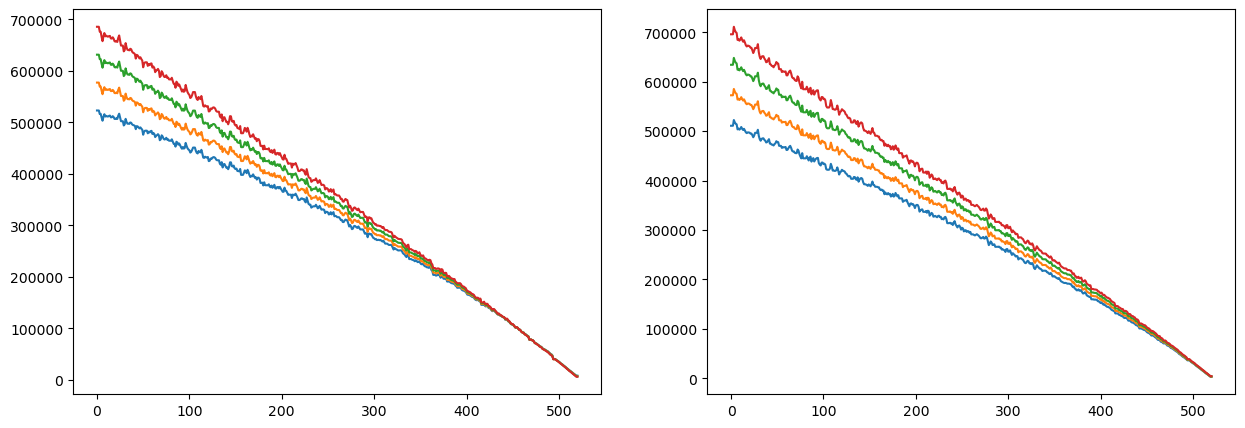

In [29]:
figure, axis = plt.subplots(1,2)
figure.set_figwidth(15)
figure.set_figheight(5)

axis[0].plot(pEE_VM1[0])
axis[0].plot(pEE_VM1[1])
axis[0].plot(pEE_VM1[2])
axis[0].plot(pEE_VM1[3])

axis[1].plot(rEE_VM1[0])
axis[1].plot(rEE_VM1[1])
axis[1].plot(rEE_VM1[2])
axis[1].plot(rEE_VM1[3])

In [30]:
df4 = pd.DataFrame({'Coupon': ['2%','4%','6%','8%'], 
                   'EPE Payer': EPE(pEE_VM1), 
                   'EPE Receiver': EPE(rEE_VM1), 
                   'EEPE Payer': EEPE(pEE_VM1), 
                   'EEPE Receiver': EEPE(rEE_VM1), 
                   'EAD Payer': EAD(EEPE(pEE_VM1),1.4,CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[0]), 
                   'EAD Receiver': EAD(EEPE(rEE_VM1),1.4,CVA(pPVEE_VM,rPVEE_VM,lambdaA,lambdaB,RA,ts,calc_type='unilateral')[1]), 
                   'M Payer': np.array([EffMat(pEE_VM1[i],dfac,ts) for i in range(0,4)]), 
                   'M Receiver': np.array([EffMat(rEE_VM1[i],dfac,ts) for i in range(0,4)])})

df4["RW Payer"] = Risk_Weight(0.005,0.6,df4["M Payer"])
df4["RW Receiver"] = Risk_Weight(0.005,0.6,df4["M Receiver"])
df4["RC Payer"] = df4["EAD Payer"] * df4["RW Payer"]
df4["RC Receiver"] = df4["EAD Receiver"] * df4["RW Receiver"]
df4 = df4.set_index('Coupon')
pd.options.display.float_format = '{:,.2f}'.format
df4

,EPE Payer,EPE Receiver,EEPE Payer,EEPE Receiver,EAD Payer,EAD Receiver,M Payer,M Receiver,RW Payer,RW Receiver,RC Payer,RC Receiver
Coupon,,,,,,,,,,,,
2%,"298,439.66","282,403.14","522,987.86","522,496.52","709,280.76","706,343.05",5.00,4.98,0.11,0.11,"74,665.24","74,177.61"
4%,"316,626.48","306,309.93","577,156.85","585,362.81","781,882.99","798,127.15",5.00,4.83,0.11,0.10,"82,308.00","82,378.66"
6%,"334,862.46","330,265.87","631,350.80","648,254.26","853,446.53","888,872.82",4.88,4.72,0.10,0.10,"88,589.56","90,459.51"
8%,"353,140.29","354,263.67","685,563.72","711,165.49","924,138.27","978,747.92",4.75,4.62,0.10,0.10,"94,457.39","98,445.51"


### Wrong Way Risk

For the remainder, assume that there is no collateral agreement in place, and also assume that there is no MPoR, i.e., $\delta = 0$. We recall from Lecture 8 that the “full-blown” definition of unilateral CVA is 

$$CVA_{U} = (1-R) \int_{0}^{T_{max}} E \left( E(t)\lambda_{A}(t)e^{-\int_{0}^{T_{max}}(r(u)+\lambda_{A}(u))du} \right) dt$$

where $R$ is recovery and $E(t)$ is the portfolio exposure, as seen from the bank’s perspective. If we assume that exposure and interest rates are approximately independent of $\lambda_{B}$, then this expression simplifies to the more common expression
$$
\begin{align}
CVA_{U} &\approx (1-R) \int_{0}^{T_{max}} PVEE(t) E\left( \lambda_{A}(t)e^{-\int_{0}^{T_{max}}\lambda_{A}(u)du} \right) dt \\
CVA_{U} &= -(1-R) \int_{0}^{T_{max}} PVEE(t) \frac{\partial X_{A}(0,t)}{\partial t} dt, \\
\end{align}
$$

where $X_{A}(0,t)$ is the risk-neutral survival probability function for $A$. Expression (2) is the one that you have used (after time discretization) in Coding Assignment 3.

Here in Coding Assignment 4, we are interested in using the bigger expression (1), as this can help us understand the effect of correlation between default intensity and exposure – the so-called Wrong-Way Risk (WWR). For this purpose, assume now that $A$’s default intensity is no longer constant at $4.5\%$, but is stochastic and driven by the model you coded up in Coding Assignment 1. Specifically, we assume that the time 0 forward intensity curve for $A$ is flat at $4.5\%$ (so $\lambda_{f,A}(0,t) = 4.5\%$ for all $t$), and that the Gaussian model parameters are $\kappa = 4\%, \sigma = 1\%$ (i.e., the same as in Coding Assignment 1).

The stochastic credit model in Coding Assignment 1 has a single Brownian motion, call it $W_{A}(t)$. The stochastic rates model in Coding Assignment 2 has two Brownian motions, so a combined model that has both stochastic credit and stochastic rates has three Brownian motions and will need a $3x3$ correlation matrix. In particular, we need to specify in a meaningful way the 2 correlations between $W_{A}(t)$ and the two rates Brownian motions. As described in your reading assignment (Section 2.4, with $Z$ here being $W_{A}$), this specification can be done by measuring the correlations between credit spreads and the short and long ends of the interest rate curve ($\rho_{l}$ and $\rho_{s}$, respectively).

### Q5 : First set ρl = ρs = 0, such that interest rates are independent of credit spreads. Compute (1) by Monte Carlo simulation (50,000 paths, as before) for par-valued receiver and payer swaps, after suitable discretization of the various integrals. (Note that we are here only interested in a single coupon, namely hpar).

In [31]:
p_l = 0
p_s = 0
l0 = 0.045
sigma = 0.01
kappa = 0.04
N = 50000

In [32]:
model4 = SwapPricer(a,b,c,rho_inf,sig_r,k2,N,T,ts)

In [33]:
CVA_U1 = model4.CVA_theoretical(l0,p_l,p_s,sigma,kappa,RA,h_par,notional)

In [34]:
df5 = pd.DataFrame({'Payer': CVA_U1[0], 
                    'Receiver': CVA_U1[1]}, index=["Unilateral CVA"])

df5

,Payer,Receiver
Unilateral CVA,"961,269.62","723,429.49"


### Q6 : Now set $\rho_{l}$ = 0.2 and $\rho_{s}$ = 0.4. Compute (1) again by Monte Carlo simulation, taking into account the non-zero correlation structure between rates and credit spreads (e.g., by using Cholesky decomposition). You should see that the two unilateral CVA numbers (one for payer, one for receiver swap) have now changed from Q5. Comment on the differences, and provide the intuition for why one number goes up and the other number goes down.

In [35]:
p_l = 0.2
p_s = 0.4

In [36]:
CVA_U2 = model4.CVA_theoretical(l0,p_l,p_s,sigma,kappa,RA,h_par,notional)

In [37]:
df6 = pd.DataFrame({'Payer': CVA_U2[0], 
                    'Receiver': CVA_U2[1]}, index=["Unilateral CVA"])

df6

,Payer,Receiver
Unilateral CVA,"1,049,801.26","623,645.57"


The risk resulting from a positive correlation between the credit exposure and the counterparty default event is known as wrong-way risk (WWR). WWR arises when there exists a positive correlation (as in our case above) between the interest rates and the default intensity. 

Wrong-way risk results in an increase in counterparty credit risk and, therefore, increases CVA. This is visible in our example above where the Unilateral CVA value of our Payer swap increases. We know that the Payer swap's DVA is the Receiver swap's CVA, which decreases in the case of Wrong Way Risk. This is also visible in our example above.